## Setup

Import the necessary libraries.

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

The hidden code cell limits the output height in colab.

In [2]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [3]:
from google.cloud import storage
import io
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/ralf/.config/gcloud/application_default_credentials.json"
os.environ['GOOGLE_CLOUD_PROJECT'] = "359515640875"
client = storage.Client()
bucket = client.get_bucket('06fff4a5ff3c1cb7a4089a63899047ff8dcd')
# Then do other things...
blob1 = bucket.get_blob('ROTVRSV')
blob2 = bucket.get_blob('DENV')
in_memory_file1 = io.BytesIO()
blob1.download_to_file(in_memory_file1)
in_memory_file1.seek(0)
in_memory_file2 = io.BytesIO()
blob2.download_to_file(in_memory_file2)
in_memory_file2.seek(0)

0

In [4]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

# Assuming your dataset is stored in a CSV file
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"

trds = pd.read_json(in_memory_file1,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()

In [13]:
def prepare_dataset1(example, label):
    return {"sentence" : example["originalTitle"]}, label

def prepare_dataset2(s):
    m = json.loads(s)
#    sp = tf.strings.split(m["originalTitle"])
#    print(sp)
#    m["prep"] = tf.RaggedTensor.from_tensor(sp, ragged_rank=1)
#    m["prep"] = tf.constant(sp)
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
#for features, label in test_ds:
#    print("features:", features)
#    print("label:", label)
#    break
    
test_cases = list(map(prepare_dataset2, test_lines))

In [18]:
#%set_cell_height 300

import tensorflow_hub as hub
import tensorflow_text as text
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
# hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
prepromodel = hub.KerasLayer("/home/ralf/models/bert-en-uncased-preprocess_3")
embedding = hub.KerasLayer("/home/ralf/models/experts-bert-pubmed_2")

sentence = tf.keras.layers.Input(shape=(), name="sentence", dtype=tf.string)
bert_inputs = prepromodel(sentence)
embedded_sentence = embedding(bert_inputs, training=False)

raw_inputs = {"sentence": sentence}
processed_inputs = {"embedded_sentence": embedded_sentence['pooled_output']}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    num_trees=500)

model_2.fit(x=train_ds)

360/360 [==============================] - 2372s 7s/step


In [19]:
model_2.compile(metrics=["accuracy"])
evaluation = model_2.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

136/136 [==============================] - 861s 6s/step - loss: 0.0000e+00 - accuracy: 0.8852
BinaryCrossentropyloss: 0.0
Accuracy: 0.8852402567863464


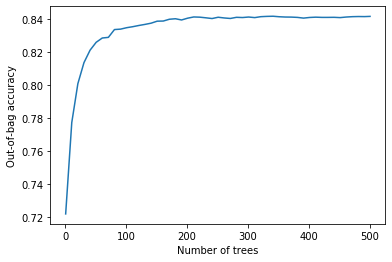

In [20]:
import matplotlib.pyplot as plt

logs = model_2.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [21]:
p = model_2.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

cut: 0.25, acc: 0.7920267311902293, prec: 0.5568535825545171, rec: 0.9563085153811859, f1: 0.7038556193601312
cut: 0.3, acc: 0.847102200714368, prec: 0.6423244251087632, rec: 0.9215336602764155, f1: 0.7570042116828419
cut: 0.35, acc: 0.8738333909436571, prec: 0.7078204199855177, rec: 0.8716005349977708, f1: 0.7812187812187812
cut: 0.39999999999999997, acc: 0.8858163382878211, prec: 0.763246425567704, rec: 0.809184128399465, f1: 0.78554425449037
cut: 0.44999999999999996, acc: 0.8888120751238622, prec: 0.8132352941176471, rec: 0.7396344181899243, f1: 0.7746906374036889
cut: 0.49999999999999994, acc: 0.885240235050121, prec: 0.8496915311273135, rec: 0.6754346856888096, f1: 0.7526080476900149
cut: 0.5499999999999999, acc: 0.8802857472058992, prec: 0.8914174252275683, rec: 0.611234953187695, f1: 0.7252049722295689
cut: 0.5999999999999999, acc: 0.870722433460076, prec: 0.9185959671396564, rec: 0.548372715113687, f1: 0.6867671691792295
cut: 0.6499999999999999, acc: 0.8564350731651111, prec: 0

In [210]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        val = int((p[i]+0.005) * 100)
        pred = False
        if val > cut:
            pred = True
        if tru != pred:
            m = {"DOI": test_cases[i]["DOI"], "pred": pred, "val": val}
            file.write(json.dumps(m))
            file.write("\n")